In [12]:
from IPython.parallel import Client
#c = Client()
c = Client(profile='parallel_python2.7')
dview = c.direct_view()
lview = c.load_balanced_view()

In [13]:
with dview.sync_imports():
    import numpy
    from mitgcmdata import MITgcmmodel, layers, budgets
    from jmd95 import eos
from matplotlib import pyplot as plt
%matplotlib inline

importing numpy on engine(s)
importing MITgcmmodel,layers,budgets from mitgcmdata on engine(s)
importing eos from jmd95 on engine(s)


In [14]:
%%px --local
#ddir = '/data/scratch/rpa/SOSE/run_np240_layers'
ddir = '/data/scratch/rpa/SOSE/run_matt'
#ddir = '/glade/scratch/rpa/SOSE/run_matt_layers'

layers_name = '1RHO'

m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter=480)

extra_mask = numpy.zeros(m.shape)
extra_mask[:,-1] = 1

Slevs = numpy.linspace(32,38,200)

drho1 = 0.002
drho2 = 0.025
rho0 = 1027.9
drho = numpy.hstack([
        drho1 * numpy.ones(100),
        numpy.linspace(drho1, drho2, 200),
        drho2 * numpy.ones(100),
])
rholevs = (rho0 - numpy.cumsum(drho))[::-1]
Nrho = len(rholevs)-1


2160 320  42
[stdout:0] 2160 320  42
[stdout:1] 2160 320  42
[stdout:2] 2160 320  42
[stdout:3] 2160 320  42
[stdout:4] 2160 320  42
[stdout:5] 2160 320  42
[stdout:6] 2160 320  42
[stdout:7] 2160 320  42


[stderr:0] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[stderr:1] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[stderr:2] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[stderr:3] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[stderr:4] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[stderr:5] 
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)
[std

In [15]:
N = 438

iter0 = 480
diters= 480
deltaTclock = 900
all_iters = range(iter0, iter0+diters*N, diters)


In [16]:
%%px --local 

salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

#Nrho = 300
#rholevs = np.linspace(1022.,1028.0,Nrho+1)

Nrho = len(rholevs)-1

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [17]:
%%px --local
deltaT = 900
#diag_freq = 2629200. # monthly
#diag_prefix = 'DiagIce-monthly'

diag_freq = 432000 # 5-day
diag_prefix= 'DiagIce-5day'

diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = numpy.round(numpy.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']

In [18]:
%%px --local

def vertical_mixing_term(niter):
    salt_budget = budgets.TracerBudget(m,
                'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                iters=niter)
    vmixing = ( salt_budget.vdiff_flux_convergence() + 
            salt_budget.kpp_flux_convergence() ) * m.drf * m.hFacC
    return vmixing

def get_dens_flux(niter):
    draw = m.rdmds(diag_prefix, niter)
    d = {}
    for n, dn in enumerate(diag_names):
        d[dn] = draw[n]
        
    salt = d['SALT']
    theta = d['THETA']
    rho, drhodt, drhods = eos.state_surface(theta, salt)

    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': numpy.ma.masked_array(d['SIempmr'], m.mask[0]),
      'AI_plus_AO': -numpy.ma.masked_array(d['SIatmFW'], m.mask[0]),
      'SIsnPrcp':  -numpy.ma.masked_array(d['SIsnPrcp'], m.mask[0])
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = numpy.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    # melt
    fw_fluxes['IO_melt'] = numpy.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    
    dens_flux_S = [ drhods * fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                    for k in fw_flux_types ]

    #dens_flux_S.append( drhods * d['WSLTMASS'] )
    
    return rho, dens_flux_S

def calc_transformation_map(rho, rholevs, dfs):

    return budgets.regrid_vertical(dfs, rho, rholevs)
    
   

In [19]:
# send iters to engines
dview.scatter('iters', all_iters)
dview.scatter('myid', c.ids)
%px print len(iters), iters[0], iters[-1]

[stdout:0] 55 480 26400
[stdout:1] 55 26880 52800
[stdout:2] 55 53280 79200
[stdout:3] 55 79680 105600
[stdout:4] 55 106080 132000
[stdout:5] 55 132480 158400
[stdout:6] 54 158880 184320
[stdout:7] 54 184800 210240


In [9]:
%%timeit
# serial
i = iter0
Nflux = len(fw_flux_types)
tr_map = numpy.zeros((Nflux, Nrho, m.Ny, m.Nx), dtype='f8')
rho, dens_flux_S = get_dens_flux(i)
for n in xrange(Nflux):
    tr_map[n] += calc_transformation_map(rho[numpy.newaxis], rholevs,
                                         dens_flux_S[n][numpy.newaxis])

NameError: global name 'fw_flux_types' is not defined

In [16]:
%%px

# parallel surface flux calculation

# set up variables
Nflux = len(fw_flux_types)
tr_map = numpy.zeros((Nflux, Nrho, m.Ny, m.Nx), dtype='f8')
#print tr_map.nbytes

# do calculation
for i in iters:
    #print i
    #tic = time.time()
    rho, dens_flux_S = get_dens_flux(i)
    for n in xrange(Nflux):
        tr_map[n] += calc_transformation_map(rho[numpy.newaxis], rholevs,
                                             dens_flux_S[n][numpy.newaxis])
    #toc = time.time()
    #print toc-tic

In [11]:
%%timeit

trmix_map = numpy.zeros((Nrho, m.Ny, m.Nx), dtype='f8')

i = iter0
theta = m.rdmds('SOstt_5d', i, rec=0)
salt = m.rdmds('SOstt_5d', i, rec=1)
rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
rho.shape = salt.shape
drhods.shape = salt.shape
vmix = drhods * vertical_mixing_term(i)
trmix_map += calc_transformation_map(rho, rholevs, vmix)

1 loops, best of 3: 15.7 s per loop


In [ ]:
%%px

# parallel mixing calculation

# set up variables
trmix_map = numpy.zeros((Nrho, m.Ny, m.Nx), dtype='f8')

# do calculation
for i in iters:
    theta = m.rdmds('SOstt_5d', i, rec=0)
    salt = m.rdmds('SOstt_5d', i, rec=1)
    rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
    rho.shape = salt.shape
    drhods.shape = salt.shape
    vmix = drhods * vertical_mixing_term(i)
    trmix_map += calc_transformation_map(rho, rholevs, vmix)
    

In [ ]:
numpy.save('/home/rpa/sose_water_mass_transformation/SOSE_layers_analysis/tmp_data/' + 
           'trmix_map_%02d' % myid[0], trmix_map)

In [22]:
%%px
numpy.save('/home/rpa/sose_water_mass_transformation/SOSE_layers_analysis/tmp_data/' + 
           'trmix_map_%02d' % myid[0], trmix_map)

In [24]:
# read and load
trmix_map = 0
for n in xrange(len(c)):
    dtmp = numpy.load('tmp_data/trmix_map_%02d.npy' % n)
    trmix_map += dtmp
    del dtmp    
trmix_map /= N
numpy.save('tmp_data/trmix_map', trmix_map)

In [21]:
# slow b/c a huge array has to get serialized
res = dview.gather('tr_map')
#tr_map = reduce(numpy.sum, res)

In [24]:
%%px
print myid
numpy.save('/home/rpa/sose_water_mass_transformation/SOSE_layers_analysis/tmp_data/tr_map_%02d' % myid[0], tr_map)


[stdout:0] [0]
[stdout:1] [1]
[stdout:2] [2]
[stdout:3] [3]
[stdout:4] [4]


In [ ]:
# read and load
tr_map = 0
for n in xrange(len(c)):
    dtmp = numpy.load('tmp_data/tr_map_%02d.npy' % n)
    tr_map += dtmp
    del dtmp    
tr_map /= N

In [ ]:
numpy.save('tmp_data/tr_map', tr_map)
numpy.save('tmp_data/rholevs', rholevs)

In [9]:
# this was slow for some reason
#all_res = lview.map_async(calc_transformation_map, diag_iters[:4])
#res = reduce(numpy.sum, all_res)

KeyboardInterrupt: 

In [58]:
tm = calc_transformation_map(diag_iters[20])

In [61]:
tm.nbytes / 1e9

15.4441728

In [ ]:
len(fw_flux_types)

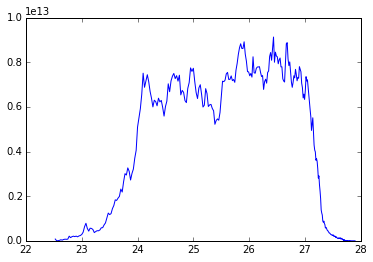

In [16]:
reload(budgets)

niter = iter0
theta = m.rdmds(diag_prefix, niter, rec=11)
salt = m.rdmds(diag_prefix, niter, rec=12)
rho, drhodt, drhods = eos.state_surface(theta, salt)

ones = numpy.ones_like(rho) * m.drf * m.hFacC * m.rac
qtr = budgets.regrid_vertical(ones[0][numpy.newaxis], rho[numpy.newaxis], rholevs)
plt.plot(rholevs[1:]-1000., qtr.sum(axis=-1).sum(axis=-1))

In [17]:
# with indexing trick
%time qtr = budgets.regrid_vertical(ones[0][numpy.newaxis], rho[numpy.newaxis], rholevs)


CPU times: user 1.41 s, sys: 393 ms, total: 1.8 s
Wall time: 1.8 s


In [19]:
reload(budgets)
# without trick
%time qtr = budgets.regrid_vertical(ones[0][numpy.newaxis], rho[numpy.newaxis], rholevs)


CPU times: user 4.58 s, sys: 583 ms, total: 5.16 s
Wall time: 5.16 s


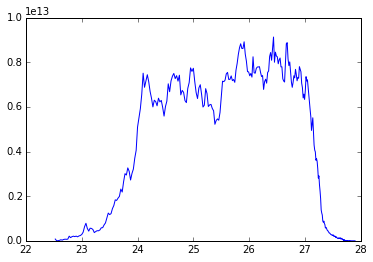

In [20]:
plt.plot(rholevs[1:]-1000., qtr.sum(axis=-1).sum(axis=-1))

In [8]:
salt_budget = budgets.TracerBudget(m,
            'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
            iters=iter0)

In [11]:
vmixing = ( salt_budget.vdiff_flux_convergence() + 
            salt_budget.kpp_flux_convergence() ) * m.drf * m.hFacC

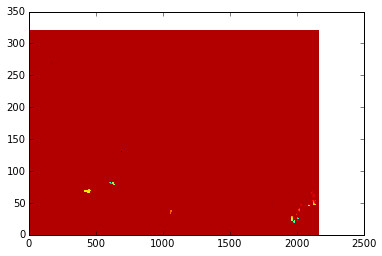

In [16]:
plt.pcolormesh(vmixing[20])